# Robert Bubble Test ｡˚○ ｡˚○ ｡˚○

<div class="alert alert-block alert-success">

## Part 3: Restarting a Simulation from a Previous Run with the `.restart` file

In this tutorial, we will showcase how to continue a simulation from its final state of a previous run. 

In the case of the Robert bubble, this will allow us to further track the evolution of the eddies that formed due to the Kelvin Helmholtz instability. For larger simulations, this is a necessary skill to have (as computing clusters often time-out and simulations need to be manually restarted).

</div>

<div class="alert alert-warning">

## $\texttt{PADDLE}$ Robert Executable Code w/ Option for Restarting 

We will be going step-by-step through the `robert_w_restart.py` found in the same directory as this notebook. 

<div class="alert alert-info">

Since we went over the executable code for the most part in Part 2, we will mostly copy the code from there up until when we implement the restart functionality. 

In [1]:
# Define the problem's free parameters

# Ps is the surface pressure
# 1 bar = 1e5 pascals 
Ps = 1.0e5 # in pascals

# surface temperature 
Ts = 303.15 # in K 

# Horizontal coordinate for center of bubble 
# In the center of the simulation
xc = 500.0 # in m 

# Vertical coordinate for center of bubble
# Slightly above the bottom of the simulation
zc = 260.0 # in m

# Maximum temperature anomaly 
dT = 0.5

# Radius of bubble 
a = 50.0 # meters

# Extent of temperature gradient from bubble's radius
s = 100.0 # meters

# Extra parameter to turn off/on on the temperature gradient from bubble's radius 
uniform_bubble = False

Import the necessary packages.

In [2]:
# Torch is the basic computational backend, equivalent in some ways to numpy but can work on CPU and GPU
import torch

# Basic package for mathematical functions
import math

# kintera is a package developed by the same developers as PADDLE and CANOE that performs thermodynamic calculations 
# see https://github.com/chengcli/kintera
import kintera

# snapy is a package developed by the same developers as PADDLE and CANOE that performs dynamical calculations 
# see https://github.com/chengcli/snapy

# Here we import the main module (MeshBlock) and options (MeshBlockOptions) used in all PADDLE simulations (explained further below)
# and the named locations of density and pressure (which we use below to define our initial condition)
from snapy import MeshBlockOptions, MeshBlock
from snapy import kIDN, kIPR

# os is used to create the output directory for outputs 
import os 

In [3]:
# User defined function to generate user output variables (uov)

# Input : bvars (block_variables, stores all the variables in the simulation)
# we will generating the block variables object in the following cells to this one

# Output: dictionary with user output variables

def call_user_output(bvars):

    # Load in the primitive variables stored by the simulation 
    # As we will see in more detail in the cells below, hydro_w is a key that signifies the primitive variables 
    # where it stores each of the primitive variable values at each cell in the simulation 
    hydro_w = bvars["hydro_w"]

    # Create the user output variable dictionary 
    out = {}

    # Manually compute temperature and potential temperature 
    # from primitive variables and equation of state properties

    # kIPR = Index of Pressure 
    # kIDN = Index of Density  

    # Rd = specific gas constant
    # Ps = surface pressure
    # cp = specific heat capacity at const pressure 
    
    # Temperature 
    temp = hydro_w[kIPR] / (Rd * hydro_w[kIDN])

    # Define it in output dictionary 
    out["temp"] = temp
    
    # Potential Temperature 
    theta = temp * (Ps / hydro_w[kIPR]).pow(Rd / cp)

    # Define it in output dictionary 
    out["theta"] = theta

    # Output the user output variable dictionary 
    return out

## Generate the $\texttt{MeshBlock}$ Object

In [4]:
# set hydrodynamic options from our yaml file
op = MeshBlockOptions.from_yaml("./robert.yaml")

# Set output directory 
# Here, make sure its the same as the one you did in Part 2 (with the final.restart file)!
output_directory = './robert_results/'
os.makedirs(output_directory, exist_ok=True)
op.output_dir(output_directory)

# initialize block 
block = MeshBlock(op)

[HydroOptions] -- constant gravity options --
* grav1 = -9.8
* grav2 = 0
* grav3 = 0


[W219 17:09:42.418052000 ProcessGroupGloo.cpp:757] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())


In [5]:
# get handles to specific modules

# Coordinates of simulation domain stored in MeshBlock
# We will need this to generate the meshgrid we will define our initial condition of the simulation on top of 
coord = block.module("coord")

# Equation of state properties stored in MeshBlock
# We will need this to generate our thermodynamic constants used when defining our initial condition 
eos = block.module("hydro.eos")

# Vertical gravity stored in MeshBlock (initialized by MeshBlockOptions)
# We will need this to generate our initial temperature condition (see Part 1, dT/dz)
grav = -block.options.hydro().grav().grav1()

In [6]:
# thermodynamic constants 

# Here we highlight an alternative way to generate c_p
# Which is mathematically equivalent to the one we define in Straka

# Adiabatic constant
# We defined this as gammad in the dynamics dictionary of the .yaml file 
gamma = eos.options.gammad()

# Specific gas constant
# We defined the molecular weight (M) in the dynamics dictionary of the .yaml file 
# Used in call_user_output to get temperature and potential temperature
# Used to set initial condition of temperature and pressure
Rd = kintera.constants.Rgas / eos.options.weight()

# Specific heat capacity at constant pressure 
# Used in call_user_output to get temperature and potential temperature
# Used to set initial condition of temperature and pressure
cp = gamma / (gamma - 1.0) * Rd

<div class="alert alert-info">

## Creating the Initial Condition w/ a `.restart` file

Here is where our code deviates. When wanting to restart a simulation from where it ended, we have to have the initial condition be the final state of the simulation. 

Here we define an `if-else` clause the checks whether or not a `robert.final.restart` exists, and if so, starts it from that point. In particular, we check to see if it exists in our defined output directory we used in Part 2 (`robert_results`), after which, the code will also use to store new outputs. 

Otherwise, it creates the initial condition we found in Part 2. 

*There might be times you want to run a simulation to some steady state and then use that state as an initial condition in a simulation with newly added physics such that the outputs are stored in a new directory. In that situation, you will need to manually create a new output directory and copy your restart file there, and then have your block object point to that new directory, before initializing the block.*


<div>

In [7]:
# Setup the meshgrid for the simulation

# coord.buffer("x1v") 
# returns a 1D tensor with length = number of cells in x1 direction + 2 x ghost zoness
# As defined in the .yaml file, this would be 64 cells + 2 x 3 ghost zones = 70

x3v, x2v, x1v = torch.meshgrid(
    coord.buffer("x3v"), coord.buffer("x2v"), coord.buffer("x1v"), indexing="ij"
)


The `Meshblock` object has a `initialize_from_restart` functionality, that can be used to directly generate the block objected from a `.restart` file. Otherwise, we set the initial condition as we did in Part 2.

In [8]:
# If there exists a robert.final.restart, run this code 
if os.path.exists("./robert_results/robert.final.restart"):

    # Use the final state of the simulation to initialize this new one
    # Note that one could use any of the .restart files here
    block_vars, current_time = block.initialize_from_restart("robert.final.restart")

    # Since the block we initialize from the restart file has the same tlim
    # That we set in the .yaml file, we need to extend it, otherwise it will 
    # immediately terminate 
    # Here we extend the simulation time by a factor of 2
    # I.e. from 1080 seconds (18 min) to 2160 seconds (36 minutes)
    initial_tlim = block.options.intg().tlim()
    block.options.intg().tlim(2.0 * block.options.intg().tlim())
    print(
        "Initialized from robert.final.restart, extending time from", 
        initial_tlim,
        "to",
        block.options.intg().tlim(),
    )


# Else, we set the initial condition manually using  the code from Part 2
else:
    # The number of points in each dimension
    # This is identical to the number of cells 
    nc3 = coord.buffer("x3v").shape[0]
    nc2 = coord.buffer("x2v").shape[0]
    nc1 = coord.buffer("x1v").shape[0]

    # Hardcode the number of variables (5 = number of primitive variables)
    nvar = 5

    # Define a 4D tensor storing primitive variables at each simulation coordinate
    # In athena++, w signifies the primitive variables 
    w = torch.zeros((nvar, nc3, nc2, nc1), device='cpu')

    # Define the spatial extent of the bubble as we did in Part 1
    r = torch.sqrt((x2v - xc) ** 2 + (x1v - zc) ** 2)

    # Set the temperature field of the entire simulation 
    # As we did in Part 1, see dT/dz
    temp = Ts - grav * x1v / cp

    # Initial Condition of the full Atmosphere's Pressure Field, defined as done in Part 1
    # Recall we define pressure before applying the bubble's temperature anomaly
    # since pressure equilibrates at the speed of sound
    w[kIPR] = Ps * torch.pow(temp / Ts, cp / Rd)

    # Add the temperature anomaly of the bubble to the temperature field
    temp += torch.where(r <= a, dT, 0.0)

    # Add the temperature gradient around the bubble 
    if not uniform_bubble:
        temp += torch.where(
            r > a,
            dT * torch.exp(-(((r - a) / s) ** 2)),
            0.0,
        )

    # Initial Condition of the full Atmosphere's Density Field, defined as done in Part 1
    w[kIDN] = w[kIPR] / (Rd * temp)


Initialized from robert.final.restart, extending time from 1080.0 to 2160.0


## Run the simulation!

<div class="alert alert-warning">

### NOTE: Your old robert.final.restart will be overwritten with a new one representing the new end state of this simulation. 

In [9]:
# Let the simulation know we created a custom call_user_output function 
# to output temperature and potential_temperature
block.set_user_output_func(call_user_output)

# Initialize the output before the simulation starts, compute until the desired time 
block.make_outputs(block_vars, current_time)

# Run the simulation in a loop
while not block.intg.stop(block.inc_cycle(), current_time):

    # Each time step of the simulation is determined by the cfl number and the sound speed 
    dt = block.max_time_step(block_vars)

    # Output to let us know the code is running
    block.print_cycle_info(block_vars, current_time, dt)

    # For each cycle, a multi-stage method (here rk3) is used to advance block_vars
    for stage in range(len(block.intg.stages)):
        block.forward(block_vars, dt, stage)

    # Check for any errors
    err = block.check_redo(block_vars)
    if err > 0:
        continue  # redo current step
    if err < 0:
        break  # terminate

    # Progress the time and make outputs 
    current_time += dt
    block.make_outputs(block_vars, current_time)

# Make the final outputs and clean up the internal states in MeshBlock
block.finalize(block_vars, current_time)

cycle=83780 redo=0 time=1.08007303049036e+03 dt=1.28943721952331e-02 mass0=1.62395950827251e+06 energy=3.44542614851752e+11
cycle=83790 redo=0 time=1.08020197417285e+03 dt=1.28943632271240e-02 mass0=1.62395950827251e+06 energy=3.44542613993396e+11
cycle=83800 redo=0 time=1.08033091776450e+03 dt=1.28943544438620e-02 mass0=1.62395950827251e+06 energy=3.44542612987415e+11
cycle=83810 redo=0 time=1.08045986127632e+03 dt=1.28943476369878e-02 mass0=1.62395950827251e+06 energy=3.44542611861006e+11
cycle=83820 redo=0 time=1.08058880473087e+03 dt=1.28943431901940e-02 mass0=1.62395950827251e+06 energy=3.44542610648245e+11
cycle=83830 redo=0 time=1.08071774814986e+03 dt=1.28943406043698e-02 mass0=1.62395950827251e+06 energy=3.44542609384970e+11
cycle=83840 redo=0 time=1.08084669154946e+03 dt=1.28943394123693e-02 mass0=1.62395950827251e+06 energy=3.44542608104333e+11
cycle=83850 redo=0 time=1.08097563494336e+03 dt=1.28943396615733e-02 mass0=1.62395950827251e+06 energy=3.44542606834297e+11
cycle=83

<div class="alert alert-warning">

## $\texttt{PADDLE}$ Robert Results

Here, we just combine the .nc files, view them in both ncview and in the notebook. 

## **IMPORTANT: We call the new combined .nc file `main2` in order to not overwrite our first simulation results**

In [10]:
!(cd robert_results/ && pd-combine 1 -o main2)

##########################
## Combine output files ##
##########################
Working on case robert...
Combining FITS output ...
Concatenating output field out1 ...
Combining output fields:  1 to main2
Done.



In [12]:
!(cd robert_results/ && ncview robert-main2.nc)

Ncview 2.1.8 David W. Pierce  8 March 2017
http://meteora.ucsd.edu:80/~pierce/ncview_home_page.html
Copyright (C) 1993 through 2015, David W. Pierce
Ncview comes with ABSOLUTELY NO WARRANTY; for details type `ncview -w'.
This is free software licensed under the Gnu General Public License version 3; type `ncview -c' for redistribution details.

Note: no Ncview app-defaults file found, using internal defaults
calculating min and maxes for rho...


Here we combine both output files into one animation

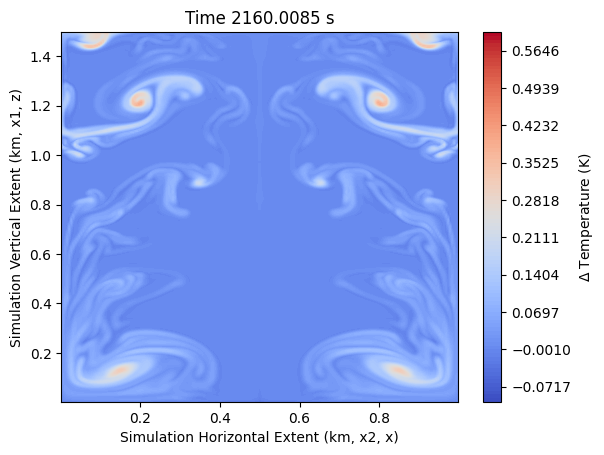

In [14]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import netCDF4
import numpy as np
import time


# Open the first main file
robert_output = netCDF4.Dataset('./robert_results/robert-main.nc', 'r')

# Lets plot the temperature 
data_temperature = robert_output.variables['temp'][:]

# Array of time for each frame, in seconds
data_time = robert_output.variables['time'][:]

# Array of center of cells for vertical direction
data_x1 = robert_output.variables['x1'][:]

# Array of center of cells for horizontal direction
data_x2 = robert_output.variables['x2'][:]

# Create meshgrid in order to plot 
Z, X = np.meshgrid(data_x2, data_x1)

# Initial temperature map to provide contrast for colormap below
temp_no_bubble = Ts - grav*X/cp

# Loop over the time saved frames 
for t in range(np.shape(data_temperature)[0]):

    # Ensures that the last plot will be cleared 
    clear_output(wait = True)

    # Make a countour plot with really fine layers to capture eddies
    plt.contourf(Z/1000,X/1000,data_temperature[t,:,0,:]-temp_no_bubble,cmap = 'coolwarm', levels = np.linspace(-0.1,0.6, 100))
    plt.colorbar(label = '$\Delta$ Temperature (K)')
    title = 'Time ' + str(data_time[t]) + ' s'
    plt.title(title)
    plt.xlabel('Simulation Horizontal Extent (km, x2, x)')
    plt.ylabel('Simulation Vertical Extent (km, x1, z)')
    plt.show()

    # Delay, so that it doesn't go too fast 
    time.sleep(0.1)


# Open the second main file
robert_output = netCDF4.Dataset('./robert_results/robert-main2.nc', 'r')

# Lets plot the temperature 
data_temperature = robert_output.variables['temp'][:]

# Array of time for each frame, in seconds
data_time = robert_output.variables['time'][:]

# Array of center of cells for vertical direction
data_x1 = robert_output.variables['x1'][:]

# Array of center of cells for horizontal direction
data_x2 = robert_output.variables['x2'][:]

# Create meshgrid in order to plot 
Z, X = np.meshgrid(data_x2, data_x1)

# Initial temperature map to provide contrast for colormap below
temp_no_bubble = Ts - grav*X/cp

# Loop over the time saved frames 
for t in range(np.shape(data_temperature)[0]):

    # Ensures that the last plot will be cleared 
    clear_output(wait = True)

    # Make a countour plot with really fine layers to capture eddies
    plt.contourf(Z/1000,X/1000,data_temperature[t,:,0,:]-temp_no_bubble,cmap = 'coolwarm', levels = np.linspace(-0.1,0.6, 100))
    plt.colorbar(label = '$\Delta$ Temperature (K)')
    title = 'Time ' + str(data_time[t]) + ' s'
    plt.title(title)
    plt.xlabel('Simulation Horizontal Extent (km, x2, x)')
    plt.ylabel('Simulation Vertical Extent (km, x1, z)')
    plt.show()

    # Delay, so that it doesn't go too fast 
    time.sleep(0.1)
